## Outline

1. Introduce dataset 
2. Data processing - Test-train split, encoding, visualisation
3. Basic RNN - testing inference
4. Evaluation and training
5. LSTM
6. GRU
7. Exercises

In [9]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
from IPython.display import clear_output #clearing the output of a cell.For instance if we want to build mutiple plots but we only want to retain only the last plot then we can do it like this programitically.


## Dataset

In [17]:
languages = []
data = []
X = []
y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip() #strip() removes left and right white padded space.
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)

In [18]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [19]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


### Train-test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) #stratify so that test and split have roughly teh same distribution.

In [21]:
print(X_train)

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko', 'Sokolsky', 'Masuno', 'Varela', 'Moffat', 'Bonner', 'Berezovsky', 'Helkvist', 'Thurston', 'Tovstuha', 'Millar', 'Tulintsev', 'Furey', 'Isaenko', 'Kalachev', 'Takecare', 'Newcombe', 'Taku', 'Artibyakin', 'Saifulov', 'Morcos', 'Jagodnikov', 'Halifman', 'Bagaryakoff', 'Pavluhin', 'Mari', 'Awramchik', 'Agaltsov', 'Fisichev', 'Shizuma', 'Yankin', 'Luts', 'Toshitala', 'Germain', 'Botros', 'Poulter', 'Lischenko', 'Porter', 'Melendez', 'Ibu', 'Carr', 'Ursler', 'Aderikhin', 'Gimondi', 'Rzhevsky', 'Slater', 'Atkin', 'Yagafarov', 'Huraskin', 'Underhill', 'Pylin', 'Yuschenko', 'Ardovini', 'Tunison', 'Dobrovolsky', 'Bezyzvestnyh', 'Roussel', 'Balakshin', 'Trumbauer', 'Vallance', 'Boerio', 'Waugh', 'Baz', 'Reading', 'Komon', 'Ireson', 'Venables', 'Tikhotsky', 'Spada', 'Winfield', 'Mikhnov', 'Lubsky', 'Antar', 'Sheehan', 'Tuma', 'Yuzefovich', 'Yamburg', 'Yukhvidov', 'Mikhail', 'Chi', 'De

In [22]:
print(len(X_train), len(X_test))

16040 4010


### Encoding names and language

In [23]:
all_letters = string.ascii_letters + " .,;'" #entire list of characters possibly we can find in a name . 
n_letters = len(all_letters)

In [24]:
print(n_letters) #26 small 26 capital and 5 special char we have chosen.

57


In [25]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters) #each character in name
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1 #one hot encoding.
    return rep

In [26]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long) #one  hot encoding for languages.

In [27]:
name_rep('Abreu')  #it has 5 chars so 5 rows.

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [28]:
lang_rep('Portuguese')

tensor([0])

In [29]:
lang_rep('Spanish')

tensor([2])

### Basic visualisation

In [30]:
count = {}
for l in languages: 
    count[l] = 0
for d in data:
    count[d[1]] += 1

In [31]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


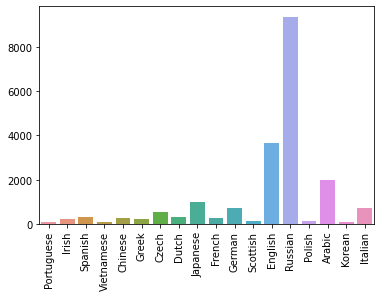

In [32]:
plt_ = sns.barplot(list(count.keys()), list(count.values())) #keys corresponds to labels and categories. and values corresponds to elements in that category.
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90) #rotation = 90 so that text dont overlap.
plt.show()

as we can see from the plot differennt lang have diff frequency so we can not have base line acccuracy with equal probability since few of the data have low prob vs few have high as they have unequal distribution. So bast line will be the probablity that is max and in this case russian freq upon total frreq is will give highest freq among all.

## Basic network and testing inference

In [33]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): #initialising all the weights adn biases and layers.
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #setting up the layers. In linear we just need to define the input and the output sizes.
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) #softmax and output for each language.

    def forward(self, input_, hidden):      
        combined = torch.cat((input_, hidden), 1) #1 represents that we are concating along a particular axis.
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self): #initialising the hidden layer special for sequence models. because initially for the firt layer we dont have the hidden layer so invoke a zero vector of hidden_size
        return torch.zeros(1, self.hidden_size)

In [35]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages) #n_letters is  character which is one hot encoded.

In [36]:
def infer(net, name):
    net.eval() #eval mode
    name_ohe = name_rep(name) #one hot encoding . It has 3 dimension - no of characteers in a word, 1, n_letters.
    hidden = net.init_hidden()
    
    for i in range(name_ohe.size()[0]): #iterating over the first dimension of name_ohe(that is iterate over each character.)
        output, hidden = net(name_ohe[i], hidden) #name_ohe[i] is tensor of size  (1, n_letters) . Output is getting overwritten so the ouput we get is the output of the last layer. hidden is always getting looped back.(means its values is passed after each computation of hidden layer.)
        #so we are calling as many forwards as characters
    
    return output #softmax taken at the last layerr.

In [37]:
output = infer(net, 'Adam')
index = torch.argmax(output)
print(output, index)

tensor([[-2.8925, -2.9005, -2.7910, -3.0115, -3.0575, -2.8763, -2.8160, -2.8314,
         -2.9539, -2.9503, -2.9032, -2.7876, -2.9474, -2.9366, -2.8117, -2.8208,
         -2.9393, -2.8492]], grad_fn=<LogSoftmaxBackward>) tensor(11)


tesnsor no 11 has the largest value.

## Evaluate model

In [38]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [39]:
dataloader(2, X_train, y_train)

[('Saga',
  'Japanese',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [40]:
def eval(net, n_points, k, X_, y_):
    
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name)
        val, indices = output.topk(k) 
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [41]:
eval(net, 1000, 3, X_test, y_test)

0.154

## Training

### Basic setup

In [42]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points

In [45]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [46]:
%%time 
train(net, opt, criterion, 200)

CPU times: user 375 ms, sys: 2.77 ms, total: 378 ms
Wall time: 383 ms


tensor(2.1259, grad_fn=<DivBackward0>)

In [47]:
eval(net, 1000, 1, X_test, y_test)

0.47

### Full training setup

In [48]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5):
    
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test), 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
                      

Iteration 99 Top-1: 0.6438902743142144 Top-2: 0.7778054862842892 Loss 1.4551587104797363


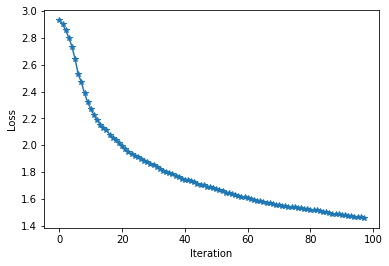

In [49]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

## LSTM cell

In [50]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2) #dimension were (1,1,-1)
    
    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden) #.view  is reshaping the inputs.1,1,(-1 means as many as their are letters in the representtation of  a given character.) #the 1st 1 means how many different inputs we want to give at tha same time. next 1 is for for batch_size.
        output = self.h2o(hidden[0]) #applying self.h2o only to the hidden state which is first element of the hidden tuple.
        output = self.softmax(output)
        return output.view(1, -1) , hidden  #flatteninng the output.
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)) #it is a tupel. Note it is differently defines as compared to RNN's. In the tuple the 0th index has dimensions (1,1,hidden_size) in which 1 represents no of layers , next 1 represents batch_size and the next dimension is the hidden_size.
        #batching has 2 advantages 1. is doing the update for the entire set of inputs. 2 is performance improvememnt.

Iteration 99 Top-1: 0.5603491271820449 Top-2: 0.686783042394015 Loss 1.8106530904769897


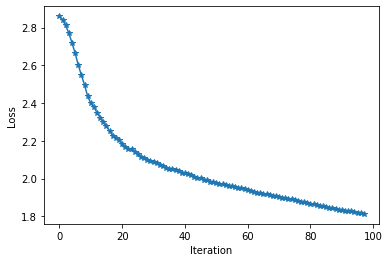

In [51]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)

## GRU Cell

In [52]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input_, hidden):
        out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

Iteration 99 Top-1: 0.5206982543640898 Top-2: 0.6907730673316709 Loss 1.8088257312774658


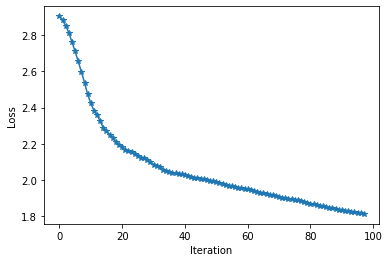

In [53]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.0005, n_batches=100, batch_size = 256)